<h1 align="center"> Market Data Mining - Forecasting <h1>


## Data Descriptions:

Full historical daily price and volume data for all US-based stocks and ETFs trading on the NYSE, NASDAQ, and NYSE MKT. The data (last updated 11/10/2017) is presented in CSV format as follows: Date, Open, High, Low, Close, Volume, OpenInt. Note that prices have been adjusted for dividends and splits.

Reference: <a href='https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/home'>Kaggle, Huge Stock Market Dataset</a>
## Table of Contents

1. **Introduction**<br><br>
2. **Time Series Modeling**<br>
a) Non-stationarity - Unit Root<br>
b) Grid Search<br>
c) Evaluation<br><br>
3. **LSTM modeling**<br>
a) Data Cleaning<br>
b) Architectures<br><br>


## Introduction:

In this notebook, I will try to build two predictive models for forecasting. The first one is a conventional example. ARIMA and SARIMAX models are suggested to fit the stock prices of Exxon Mobile. The second approach is more trendy and by far one of the most complex model for time series forecasting. A deep neural network with LSTM layers are trained on the entire dataset, i.e., stock prices records of over thousands of companies. Lastly, I will compare the pros and cons of the two models.

In [268]:
# Warning Off
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling
import pandas as pd
import numpy as np

# File names extractor
from glob import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, iplot_mpl 
from plotly.graph_objs import *

init_notebook_mode()
%matplotlib inline

# Iteration Tool
from tqdm import tqdm

# Time Series Modeling
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os

In [2]:
stock_fnames = glob("./Stocks/*")

## This function is to import all stock price records. Will be used for LSTM part. 
def get_all_df(fnames):
    
    df = []
    empty_fnames = []
    
    for fname in fnames[:1]:
        try:
            temp = pd.read_csv(fname)
            # create 'label' column - name of companies
            temp['label'] = fname.split('/')[2].split('.')[0]
            df.append(temp)
            
        except:
            # some files are empty... error?
            print('exception: {} deleted'.format(fname))
            empty_fnames.append(fname)
            os.remove(fname)
            
    print('{} files out of {} files are empty!'.format(len(empty_fnames), len(fnames)))
    
    return pd.concat(df)

In [3]:
## Exxon Mobile data imported
df = pd.read_csv("./Stocks/xom.us.txt")
df.head()

Date    Open    High     Low   Close   Volume  OpenInt
0  1970-01-02  1.4972  1.4972  1.4893  1.4972  1459617        0
1  1970-01-05  1.4972  1.5297  1.4972  1.5297  2338570        0
2  1970-01-06  1.5297  1.5297  1.5055  1.5216  1531212        0
3  1970-01-07  1.5216  1.5216  1.5138  1.5138  1141448        0
4  1970-01-08  1.5138  1.5297  1.5055  1.5138  1336326        0

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['close_diff'] = df['Close'].diff()
df = df.iloc[1:,:]
df.set_index('Date', inplace=True)

In [5]:
df.head(2)

Open    High     Low   Close   Volume  OpenInt  close_diff
Date                                                                    
1970-01-05  1.4972  1.5297  1.4972  1.5297  2338570        0      0.0325
1970-01-06  1.5297  1.5297  1.5055  1.5216  1531212        0     -0.0081

In [6]:
df.tail(2)

Open    High     Low  Close    Volume  OpenInt  close_diff
Date                                                                    
2017-11-09  82.536  83.368  82.318  83.20  10575654        0       0.495
2017-11-10  83.010  83.080  82.420  82.94   8693290        0      -0.260

In [7]:
# No missing values
df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
OpenInt       0
close_diff    0
dtype: int64

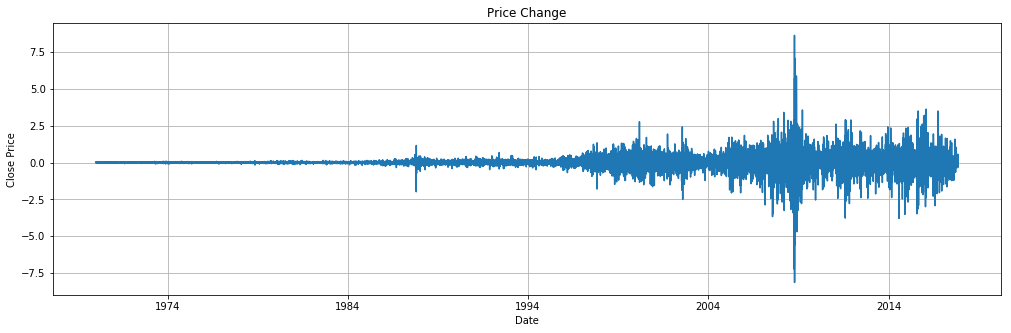

In [8]:
plt.figure(figsize=(17, 5))
sns.lineplot(df.index, df['close_diff'], palette='darkgrid')
plt.title(s="Price Change")
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

I will cut off the time points before 2000 to focus on more fluctuating period of time. 

<br>
<br>
## Time Series Modeling

### Non-Stationarity - Unit Root

First, I will explore the seasonality, trend, and noise of the price records. Stock price records are often non-stationary or have means, variances and covariances that change over time. Non-stationary behaviors can be trends, cycles, random walks or combinations of the three.

Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted. The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data. In contrast to the non-stationary process that has a variable variance and a mean that does not remain near, or returns to a long-run mean over time, the stationary process reverts around a constant long-term mean and has a constant variance independent of time.

**Reference**: Introduction To Stationary And Non-Stationary Processes - Investopia

In [9]:
X = df.loc['2000':, 'Close'].resample('D').pad()
X.head()

Date
2000-01-03    30.676
2000-01-04    30.102
2000-01-05    31.737
2000-01-06    33.363
2000-01-07    33.258
Freq: D, Name: Close, dtype: float64

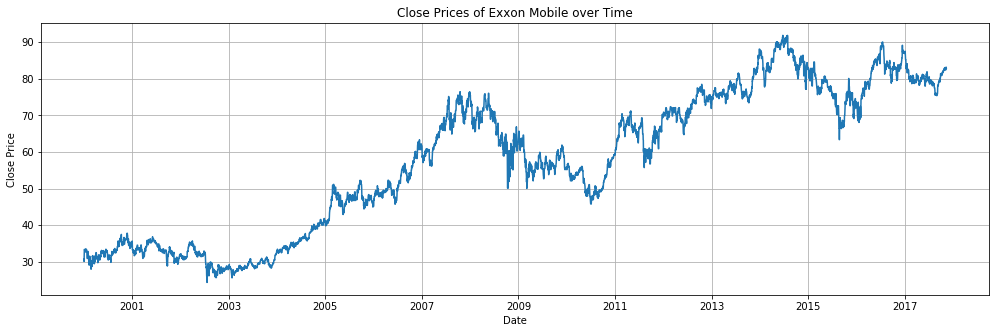

In [10]:
plt.figure(figsize=(17, 5))
sns.lineplot(X.index, X)
plt.grid(True)
plt.title(s="Close Prices of Exxon Mobile over Time")
plt.ylabel('Close Price')
plt.show()

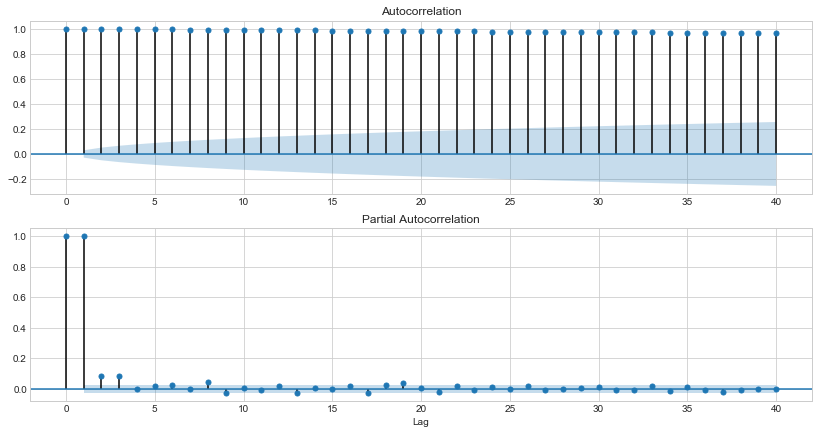

In [11]:
plt.style.use('seaborn-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))
sm.graphics.tsa.plot_acf(df.loc['2000':,'Close'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df.loc['2000':,'Close'], lags=40, ax=ax2)
ax2.set_xlabel("Lag")
plt.show()

The above ACF is “decaying”, or decreasing, very slowly, and remains well above the significance range (dotted blue lines). This is indicative of a non-stationary series. For a stationary series, you would ultimately expect to see autocorrelations to decay to zero at higher lags

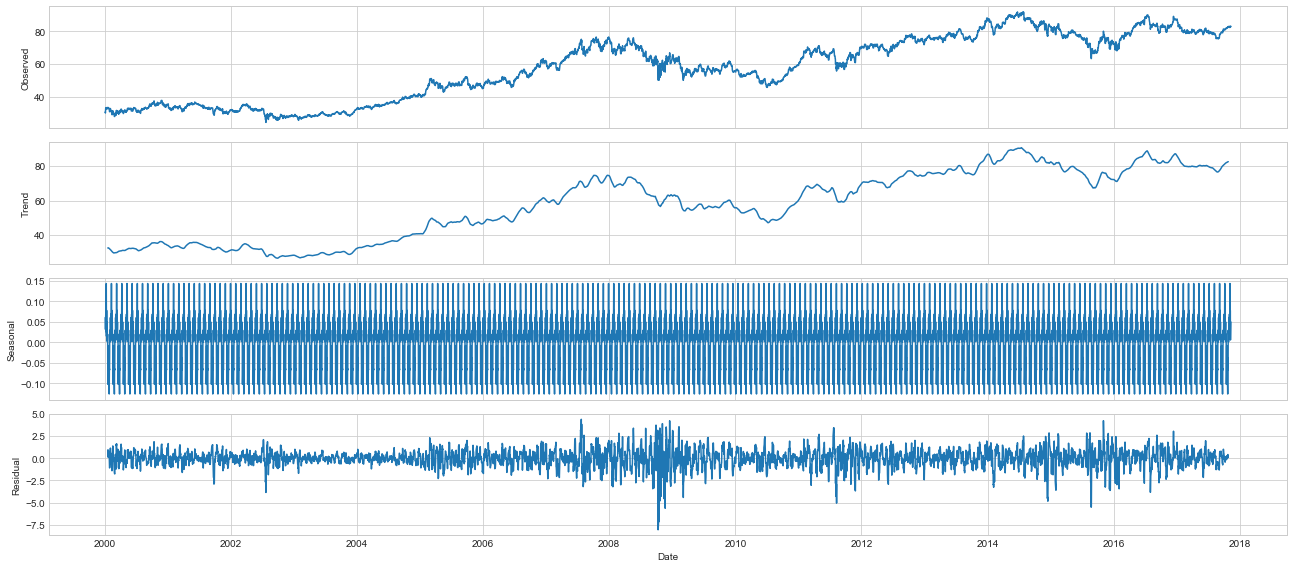

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = (18, 8)

decomposition = sm.tsa.seasonal_decompose(X, model='additive', freq=30)

fig = decomposition.plot()
plt.show()

Here is another indicator of non-stationary time series. The data has a clear trend and unstable variance of residuals over time. 

### What is “Unit Root”?
A unit root (also called a unit root process or a difference stationary process) is a stochastic trend in a time series, sometimes called a “random walk with drift”; If a time series has a unit root, it shows a systematic pattern that is unpredictable.

### Unit Root Test?
Unit root tests are tests for stationarity in a time series
- The Dickey Fuller Test 
- lliott–Rothenberg–Stock Test
- Schmidt–Phillips Test

If there is a unit root in stock prices, then this implies that stock market
returns cannot be predicted from previous prices changes and in line with the view of the efficient
market hypothesis. 

**Reference**:<a src='https://core.ac.uk/download/pdf/6421179.pdf'> Shyh-Wei Chen, "Non-stationarity and Non-linearity in Stock Prices: Evidence from the OECD Countries"</a>

I will difference the data by lag 1 in the attempt to gain a stationary time series. Then, I will transform the data by taking a logarithm to remedy the change in variance over time. From now on, our data becomes a daily return of the stock.

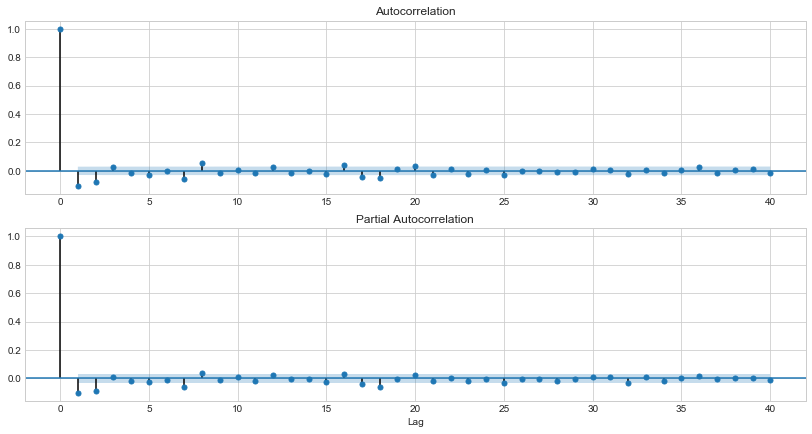

In [13]:
# Daily returns are used instead of the closing prices
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))
sm.graphics.tsa.plot_acf(df.loc['2000':, 'close_diff'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df.loc['2000':, 'close_diff'], lags=40, ax=ax2)
ax2.set_xlabel("Lag")
plt.show()

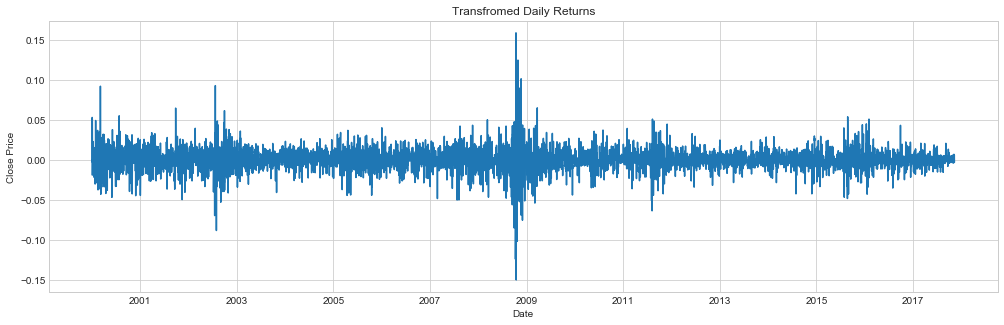

In [14]:
# difference by lag 1
X_diff_1 = np.log(X).diff()[1:]

# Take a logarithm on the return
plt.figure(figsize=(17, 5))
sns.lineplot(X_diff_1.index, X_diff_1, palette='darkgrid')
plt.title(s="Transfromed Daily Returns")
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [15]:
# Stationary test
df_test = sm.tsa.stattools.adfuller(X_diff_1)
print("p-value of augmented Dickey-Fuller test: {}".format(df_test[1]))

p-value of augmented Dickey-Fuller test: 6.682067633041614e-30


The p-value of the test is far less than 0.01. This is a strong indicator that the daily returns are stationary.

## Grid Search

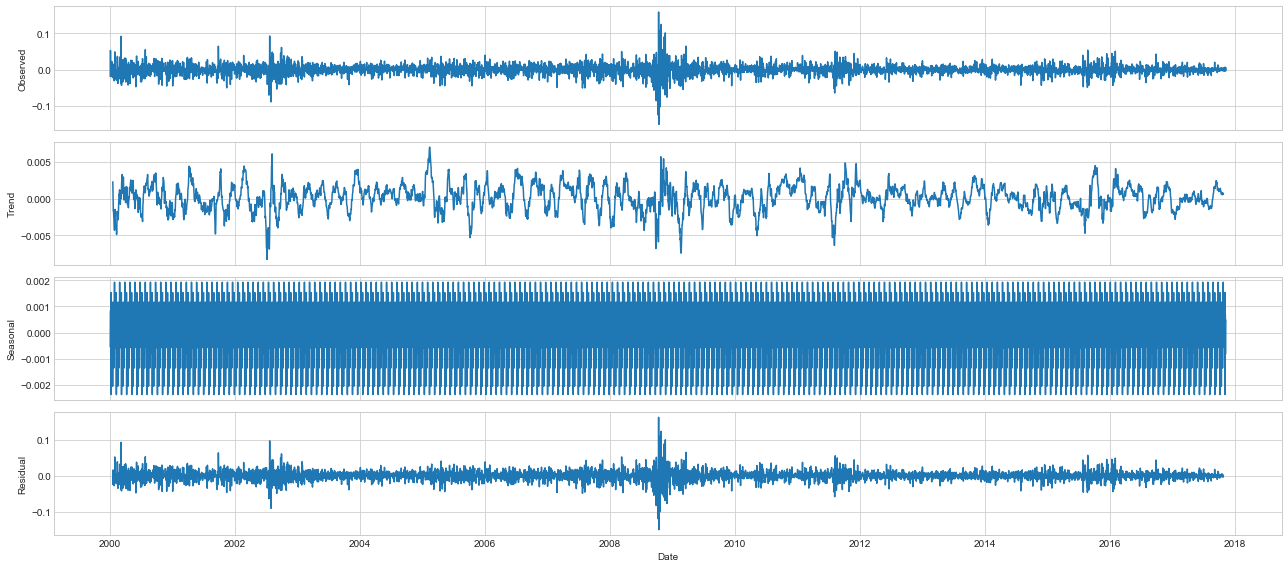

In [16]:
decomposition = sm.tsa.seasonal_decompose(X_diff_1, model='additive', freq=30)

fig = decomposition.plot()

plt.show()

In [17]:
# The simplest way to determine optimal p and q 
res = sm.tsa.arma_order_select_ic(X_diff_1, ic='aic', trend='nc')
res

{'aic':               0             1             2
 0           NaN -38474.151108 -38486.049113
 1 -38468.341930 -38495.146061 -38484.925409
 2 -38483.103301 -38496.311325           NaN
 3 -38481.325990 -38497.815595 -38500.854401
 4 -38505.873405 -38504.022576 -38502.670631, 'aic_min_order': (4, 0)}

In [18]:
arima_4_1_0 = ARIMA(np.log(X), order=(4, 1, 0))
result = arima_4_1_0.fit(dist=False)
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6521
Model:                 ARIMA(4, 1, 0)   Log Likelihood               19258.649
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 18 Dec 2018   AIC                         -38505.298
Time:                        14:31:13   BIC                         -38464.601
Sample:                    01-04-2000   HQIC                        -38491.224
                         - 11-10-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.194      0.233   -9.74e-05       0.000
ar.L1.D.Close    -0.0982      0.012     -7.943      0.000      -0.122      -0.074
ar.L2.D.Close    -0.0548      0.012     

In [19]:
pred = np.exp(result.predict(start=pd.to_datetime('2017-01-01'), dynamic=False))
pred_ci = result.conf_int()

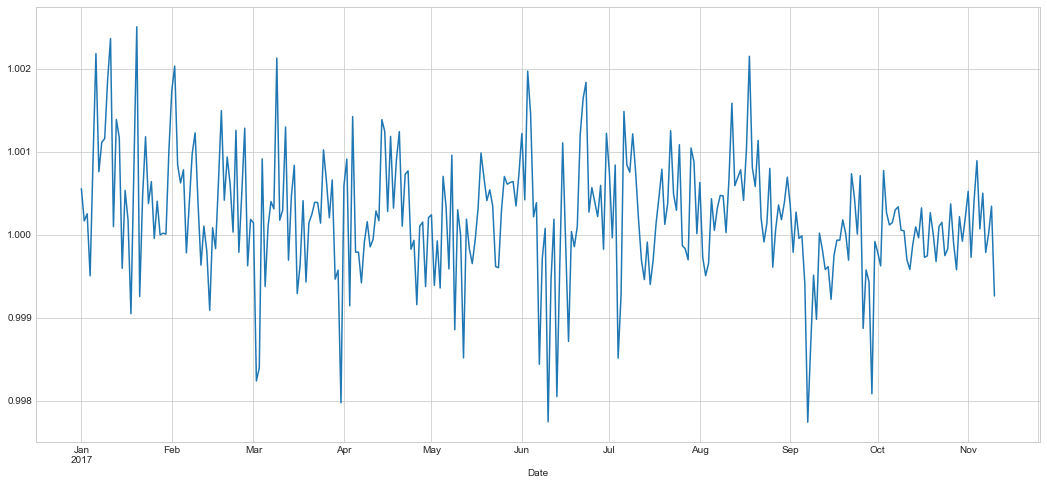

In [20]:
pred.plot()
plt.grid(True)

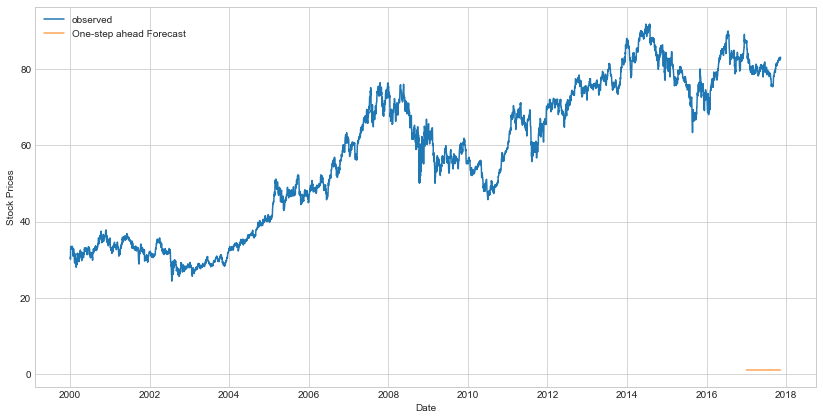

In [23]:
ax = X['2000':].plot(label='observed')
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Stock Prices')
plt.legend()
plt.show()

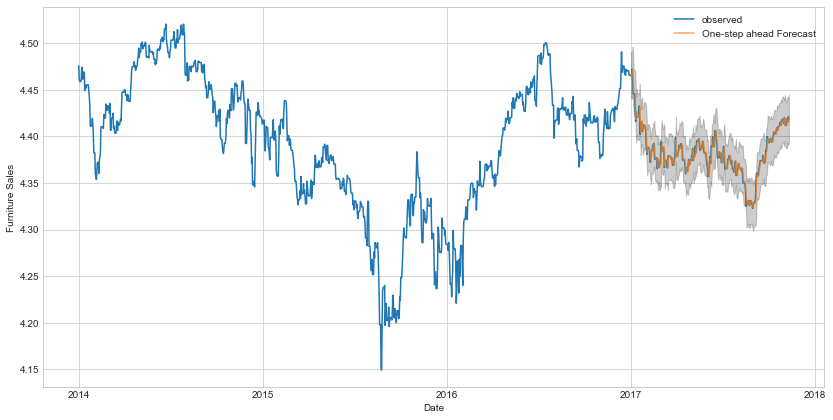

In [33]:
model = sm.tsa.SARIMAX(np.log(X), order=(4,1,0))
result = model.fit()

y = np.log(X)

pred = result.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

<br>
<br>
## LSTM Modeling

A LSTM network is a kind of recurrent neural network. A recurrent neural network is a neural network that attempts to model time or sequence dependent behaviour – such as language, stock prices, electricity demand and so on. This is performed by feeding back the output of a neural network layer at time t to the input of the same network layer at time t + 1. 

### Data Cleaning

In order to implement lstm layers, the data need to be transformed into sliding windows

In [8]:
## Exxon Mobile data imported
df = pd.read_csv("./Stocks/xom.us.txt")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [176]:
# Truncate before 2000
df_2000 = df['2000':].drop('OpenInt', axis=1)
window_len = 10

# Interpolation for missing values
df_2000.loc[df_2000['Volume'] == 0, 'Volume'] = np.nan
df_2000['Volume'].interpolate(inplace=True)

# Train, Test split
split_date = df_2000.index[-window_len*50]
train = df_2000[:split_date].values
test = df_2000[split_date:].values

# Sliding windows
def make_sliding_windows(df, window_len):

    df_len = df.shape[0]
    temp = []
    
    for i in range(df.shape[0]//window_len):
        for j in range(window_len):
            try:
                tensor = df[i*window_len+j : (i+1)*window_len+j]/df[i*window_len+j]
                if tensor.shape[0] == 10:
                    if np.isnan(tensor).any(): print(i, j)
                    temp.append(df[i*window_len+j : (i+1)*window_len+j]/df[i*window_len+j])
            except:
                pass
    
    X = np.array(temp)[:-1]
    y = df[window_len:,3]/df[:-window_len,3] # 3: column of 'Close'
    
    return X, y

X_train, y_train = make_sliding_windows(train, window_len)
X_test, y_test = make_sliding_windows(test, window_len) 

<br>
<br>
## Architectures

In [10]:
# build architecture
input_shape = [X_train.shape[1], X_train.shape[2]]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='elu'))
model.add(Dense(1))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 68,097
Trainable params: 67,969
Non-trainable params: 128
_________________________________________________________________


In [13]:
callbacks = [ModelCheckpoint('best_LSTM.h5')]

model.compile(optimizer=Adam(lr=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, callbacks=callbacks,
         validation_data=(X_test, y_test))

Train on 3985 samples, validate on 490 samples
Epoch 1/30
3985/3985 [==============================] - 4s 1ms/step - loss: 0.6971 - mean_absolute_error: 0.6971 - val_loss: 0.6109 - val_mean_absolute_error: 0.6109
Epoch 2/30
3985/3985 [==============================] - 2s 507us/step - loss: 0.2560 - mean_absolute_error: 0.2560 - val_loss: 0.3789 - val_mean_absolute_error: 0.3789
Epoch 3/30
3985/3985 [==============================] - 2s 513us/step - loss: 0.1211 - mean_absolute_error: 0.1211 - val_loss: 0.3868 - val_mean_absolute_error: 0.3868
Epoch 4/30
3985/3985 [==============================] - 2s 517us/step - loss: 0.1035 - mean_absolute_error: 0.1035 - val_loss: 0.3647 - val_mean_absolute_error: 0.3647
Epoch 5/30
3985/3985 [==============================] - 2s 512us/step - loss: 0.0989 - mean_absolute_error: 0.0989 - val_loss: 0.4058 - val_mean_absolute_error: 0.4058
Epoch 6/30
3985/3985 [==============================] - 2s 511us/step - loss: 0.0910 - mean_absolute_error: 0.0910 

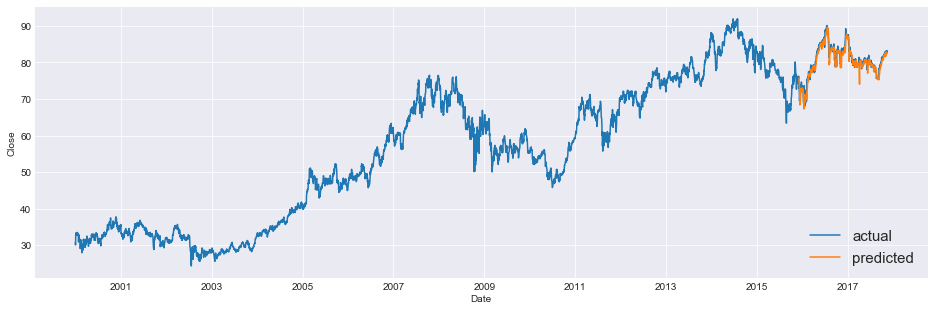

In [296]:
# Original values
actual = test[:, 3][:-window_len] * y_test
pred = test[:, 3][:-window_len] * model.predict(X_test).squeeze()

# Visualization
plt.style.use('seaborn-darkgrid')

plt.figure(figsize=(16, 5))
sns.lineplot(df_2000.index, df_2000['Close'], label = "actual")
sns.lineplot(df_2000[split_date:].iloc[10:,:].index, pred, label = "predicted")
plt.legend(fontsize=15, loc='lower right')
plt.grid(True)
plt.show()

<br>
# Time-Series Cross Validation

### Reasons:

- The one-step forward predictions seem reasonably close to the actual values of the test set. However, it is not enough to measure the performance of the model by bare eyes.
- Also, there is a hyper-parameter of the model, the number of memory cells of LSTM layers and the number of LSTM layers. In the experiement above, nothing has been confirmed regarding the relative efficiency of the hyper-parameters.
- I will do a cross-validation to better monitor the performance of the models. In the meantime, I will try to identify the best hyper-parameters.
- Cross-validation on a time series data has a different procedure than that on those data without temporal context. Sklearn module has TimeSeriesSplit class to simplify this process

In [275]:
X, y = make_sliding_windows(train, window_len)
X_test, y_test = make_sliding_windows(test, window_len) 

In [273]:
def build_model(n_LSTM=2, n_memory_cells=64, p_dropout=0.3, 
                batch_normalization=True, n_fully_connected=256, *args, **kargs):

    input_shape = [X_train.shape[1], X_train.shape[2]]

    model = Sequential()
    
    first = True
    last = False
    for i in range(n_LSTM):
        
        if first:
            if n_LSTM != 1:
                model.add(LSTM(n_memory_cells, return_sequences=True, input_shape=input_shape, name='LSTM1'))
            elif n_LSTM == 1:
                model.add(LSTM(n_memory_cells, input_shape=input_shape, name='LSTM1'))
        elif not last:
            model.add(LSTM(n_memory_cells, return_sequences=True, name='LSTM{}'.format(i+1)))
        elif last:
            model.add(LSTM(n_memory_cells, name='LSTM{}'.format(n_LSTM)))
        
        first = False
        last = True if (i == n_LSTM - 2) else False
    
    if p_dropout > 0:
        model.add(Dropout(p_dropout, name='DropOut'))
    
    if BatchNormalization:
        model.add(BatchNormalization(name='BatchNormalization'))
        
    if n_fully_connected > 0:
        model.add(Dense(n_fully_connected, activation='elu', name='Dense1'))
        
    model.add(Dense(1, name='Dense2'))
    
    return model    

def cv_model(X_train, y_train, X_test, y_test, **kargs):
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=1)]
    model = build_model(**kargs)
    model.compile(optimizer=Adam(lr=kargs['learning_rate']), loss='mse')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        batch_size=kargs['n_batch'], epochs=100, verbose=0, callbacks=callbacks)
    
    pred = model.predict(X_test)
    metrics = (mean_squared_error(y_test, pred), mean_absolute_error(y_test, pred))
    
    return model, metrics, history
    
def choose_param_grid(param_grid):
            
    items = sorted(param_grid.items())    
    keys, values = zip(*items)
    
    res = []
    for v in product(*values):
        params = dict(zip(keys, v))
        res.append(params)
    return res

In [277]:
split = TimeSeriesSplit(n_splits=3)

param_grid = {'n_LSTM': [1,2,3,4],
              'n_memory_cells': [16, 32, 64],
              'p_dropout': [0, 0.3, 0.6],
              'batch_normalization': [True, False],
              'n_fully_connected': [0, 128, 256, 512],
              'learning_rate': [1e-3, 1e-4, 1e-5],
              'n_batch': [32, 64, 128]}
              
n_random_search = 50

tested_params = []
performance = []
histories = []

random_param_sets = np.random.choice(choose_param_grid(param_grid), n_random_search)

local_best_metrics = [float('inf'), 0]

for i in range(n_random_search):
    temp_mse = []
    for train_index, test_index in split.split(X):
        X_train_cv, y_train_cv = X[train_index], y[train_index]
        X_test_cv, y_test_cv = X[test_index], y[test_index]
        
        (model, metrics, history) = cv_model(X_train_cv, y_train_cv, X_test_cv, y_test_cv, **random_param_sets[i])
        temp_mse.append(metrics)
    
    mean_metrics = np.array(temp_mse).mean(axis=0)
    rounded_metrics = list(map(functools.partial(round, ndigits=3), 
                  mean_metrics*100))
        
    tested_params.append(random_param_sets[i])
    performance.append(rounded_metrics)
    histories.append(history)
    
    if mean_metrics[0] < local_best_metrics[0]:
        best_estimator_ = model
        local_best_metrics = mean_metrics    
        
    print(random_param_sets[i])
    print("MSE: {}, MAE: {} ".format(*rounded_metrics))

{'batch_normalization': True, 'learning_rate': 0.0001, 'n_LSTM': 3, 'n_batch': 64, 'n_fully_connected': 256, 'n_memory_cells': 16, 'p_dropout': 0}
MSE: 2.374, MAE: 13.007 
{'batch_normalization': False, 'learning_rate': 0.0001, 'n_LSTM': 2, 'n_batch': 32, 'n_fully_connected': 512, 'n_memory_cells': 64, 'p_dropout': 0}
MSE: 13.546, MAE: 35.91 
{'batch_normalization': True, 'learning_rate': 0.0001, 'n_LSTM': 4, 'n_batch': 128, 'n_fully_connected': 256, 'n_memory_cells': 64, 'p_dropout': 0.3}
MSE: 3.594, MAE: 12.659 
{'batch_normalization': True, 'learning_rate': 1e-05, 'n_LSTM': 1, 'n_batch': 32, 'n_fully_connected': 0, 'n_memory_cells': 32, 'p_dropout': 0.6}
MSE: 73.318, MAE: 85.241 
{'batch_normalization': False, 'learning_rate': 0.0001, 'n_LSTM': 4, 'n_batch': 128, 'n_fully_connected': 256, 'n_memory_cells': 64, 'p_dropout': 0.6}
MSE: 26.203, MAE: 49.875 
{'batch_normalization': False, 'learning_rate': 0.001, 'n_LSTM': 4, 'n_batch': 32, 'n_fully_connected': 0, 'n_memory_cells': 64, 'p

KeyboardInterrupt: 

In [ ]:
split = TimeSeriesSplit(n_splits=3)

param_grid = {'n_LSTM': [3,4,5,6,7],
              'n_memory_cells': [16, 32, 64],
              'p_dropout': [0, 0.3, 0.6],
              'batch_normalization': [True, False],
              'n_fully_connected': [0, 128, 256, 512],
              'learning_rate': [1e-1, 1e-2, 1e-3],
              'n_batch': [16, 32, 64]}
              
n_random_search = 50

tested_params = []
performance = []
histories = []

random_param_sets = np.random.choice(choose_param_grid(param_grid), n_random_search)

local_best_metrics = [float('inf'), 0]

for i in range(n_random_search):
    temp_mse = []
    for train_index, test_index in split.split(X):
        X_train_cv, y_train_cv = X[train_index], y[train_index]
        X_test_cv, y_test_cv = X[test_index], y[test_index]
        
        (model, metrics, history) = cv_model(X_train_cv, y_train_cv, X_test_cv, y_test_cv, **random_param_sets[i])
        temp_mse.append(metrics)
    
    mean_metrics = np.array(temp_mse).mean(axis=0)
    rounded_metrics = list(map(functools.partial(round, ndigits=3), 
                  mean_metrics*100))
        
    tested_params.append(random_param_sets[i])
    performance.append(rounded_metrics)
    histories.append(history)
    
    if mean_metrics[0] < local_best_metrics[0]:
        best_estimator_ = model
        local_best_metrics = mean_metrics    
        
    print(random_param_sets[i])
    print("MSE: {}, MAE: {}, n_epoch: {} ".format(*rounded_metrics, len(history)))

{'batch_normalization': False, 'learning_rate': 0.001, 'n_LSTM': 4, 'n_batch': 32, 'n_fully_connected': 0, 'n_memory_cells': 16, 'p_dropout': 0.3}
MSE: 0.138, MAE: 2.836 
{'batch_normalization': True, 'learning_rate': 0.1, 'n_LSTM': 5, 'n_batch': 64, 'n_fully_connected': 128, 'n_memory_cells': 64, 'p_dropout': 0.6}
MSE: 0.949, MAE: 7.745 
{'batch_normalization': False, 'learning_rate': 0.001, 'n_LSTM': 6, 'n_batch': 64, 'n_fully_connected': 128, 'n_memory_cells': 16, 'p_dropout': 0.6}
MSE: 0.172, MAE: 3.228 
{'batch_normalization': False, 'learning_rate': 0.001, 'n_LSTM': 4, 'n_batch': 64, 'n_fully_connected': 256, 'n_memory_cells': 16, 'p_dropout': 0.3}
MSE: 0.229, MAE: 3.876 
